In [63]:
# TASK 3
# Reference- https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/

In [64]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
# extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	image = Image.open(filename)
	image = image.convert('RGB')
	pixels = asarray(image)
	return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
	faces = model.detect_faces(pixels)
	if len(faces) == 0:
		return None
	# extracting face details
	x1, y1, width, height = faces[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	model = MTCNN()
	faces = list()
	for filename in listdir(directory):
		pixels = load_image(directory + filename)
		face = extract_face(model, pixels)
		if face is None:
			continue
		faces.append(face)
		print(len(faces), face.shape)
		if len(faces) >= n_faces:
			break
	return asarray(faces)

directory = "/content/drive/MyDrive/Colab Notebooks/AdvML-Spring'23/792-HW3/img_align_test/"
all_faces = load_faces(directory, 11565)
print('Loaded: ', all_faces.shape)
savez_compressed('img_align_celeba.npz', all_faces)

1/1 [==============================] - 0s 296ms/step
1 (80, 80, 3)
1/1 [==============================] - 0s 64ms/step
2 (80, 80, 3)
1/1 [==============================] - 0s 42ms/step
3 (80, 80, 3)
1/1 [==============================] - 0s 38ms/step
4 (80, 80, 3)
1/1 [==============================] - 0s 37ms/step
5 (80, 80, 3)
1/1 [==============================] - 0s 34ms/step
6 (80, 80, 3)
1/1 [==============================] - 0s 32ms/step
7 (80, 80, 3)
1/1 [==============================] - 0s 35ms/step
8 (80, 80, 3)
1/1 [==============================] - 0s 36ms/step
9 (80, 80, 3)
1/1 [==============================] - 0s 38ms/step
10 (80, 80, 3)
1/1 [==============================] - 0s 35ms/step
11 (80, 80, 3)
1/1 [==============================] - 0s 42ms/step
12 (80, 80, 3)
1/1 [==============================] - 0s 46ms/step
13 (80, 80, 3)
1/1 [==============================] - 0s 48ms/step
14 (80, 80, 3)
1/1 [==============================] - 0s 56ms/step
15 (80, 80, 3)
1/1

In [66]:
# usinh gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [133]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))

	opt = Adam(lr=0.001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [134]:
# defining the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

In [135]:
# defining the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [137]:
# loading & preparing training images
def load_real_samples():
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [138]:
# selecting real samples
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

In [139]:
# generating points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [140]:
# the generator will generate n fake examples, along with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

In [141]:
# training generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [142]:
#saving the plot of generated images
def save_plot(examples, epoch, n=10):
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluating the discriminator, plot generated images and saving generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [143]:
latent_dim = 100    # size of the latent space
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 6s 2s/step
Accuracy real: 37%, fake: 84%


4/4 [==============================] - 7s 1s/step
Accuracy real: 36%, fake: 87%


1/1 [==============================] - 2s 2s/step


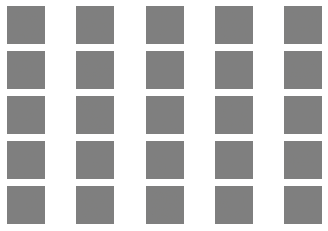

In [147]:
# loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

def plot_generated(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

model = load_model('generator_model_030.h5')
latent_points = generate_latent_points(100, 25)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
plot_generated(X, 5)

1/1 [==============================] - 1s 649ms/step


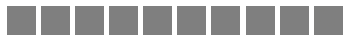

In [145]:
# interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

def plot_generated(examples, n):
	for i in range(n):
		pyplot.subplot(1, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

model = load_model('generator_model_030.h5')
pts = generate_latent_points(100, 2)
interpolated = interpolate_points(pts[0], pts[1])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_generated(X, len(interpolated))

1/1 [==============================] - 0s 488ms/step


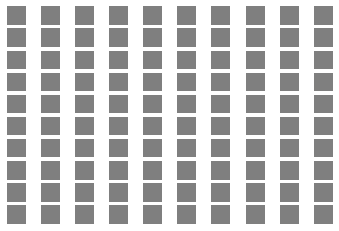

In [79]:
from numpy import vstack

def plot_generated(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

model = load_model('generator_model_030.h5')
n = 20
pts = generate_latent_points(100, n)
results = None
for i in range(0, n, 2):
	interpolated = interpolate_points(pts[i], pts[i+1])
	X = model.predict(interpolated)
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))

plot_generated(results, 10)

1/1 [==============================] - 0s 484ms/step


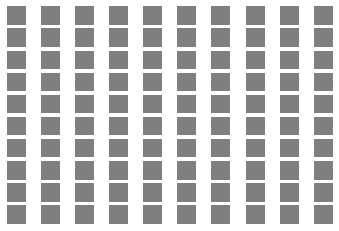

In [80]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

def interpolate_points(p1, p2, n_steps=10):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

model = load_model('generator_model_030.h5')
n = 20
pts = generate_latent_points(100, n)
results = None
for i in range(0, n, 2):
	interpolated = interpolate_points(pts[i], pts[i+1])
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))

plot_generated(results, 10)

In [81]:
def plot_generated(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.savefig('generated_faces.png')
	pyplot.close()

model = load_model('generator_model_030.h5')
latent_points = generate_latent_points(100, 100)
savez_compressed('latent_points.npz', latent_points)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
plot_generated(X, 10)

4/4 [==============================] - 5s 1s/step


1/1 [==============================] - 1s 1s/step


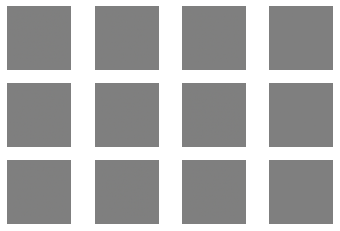

1/1 [==============================] - 0s 131ms/step


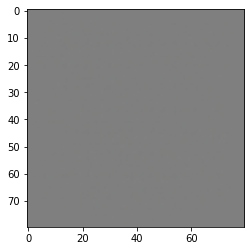

In [82]:
from numpy import load
from numpy import mean
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	zero_ix = [i-1 for i in ix]
	vectors = points[zero_ix]
	avg_vector = mean(vectors, axis=0)
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

def plot_generated(examples, rows, cols):
	for i in range(rows * cols):
		pyplot.subplot(rows, cols, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

model = load_model('generator_model_030.h5')
smiling_woman_ix = [92, 98, 99]
neutral_woman_ix = [9, 21, 79]
neutral_man_ix = [10, 30, 45]
data = load('latent_points.npz')
points = data['arr_0']
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
images = model.predict(all_vectors)
images = (images + 1) / 2.0
plot_generated(images, 3, 4)
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()